In [271]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import re
import pandas as pd
import os
import time
import random
from string import digits
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [10]:
# URL component lists
base = 'https://www.opensecrets.org/industries/summary.php?'
cycles = ['2014', '2016', '2018', '2020']
industries = ['Q13', 'Q12', 'H04'] # gun rights, gun control, pharmaceuticals
chambers = ['S', 'H'] # senate and house
# &mem=N , because we only want elected officials since they're in position to act on laws
urls = []
for cycle in cycles:
    for industry in industries:
        for chamber in chambers:
            url = base + '&ind='+industry+'&cycle='+cycle+'&recipdetail='+chamber+'&mem=Y'
            urls.append(url)
# https://www.opensecrets.org/industries/summary.php?&ind=Q13&cycle=2017&recipdetail=S&mem=N

# helper methods

In [130]:
urls[1].index('Q13')

56

In [131]:
urls[1][56:]

'Q13&cycle=2014&recipdetail=H&mem=Y'

In [129]:
for url in urls:
    print(url, '\n')

https://www.opensecrets.org/industries/summary.php?&ind=Q13&cycle=2014&recipdetail=S&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=Q13&cycle=2014&recipdetail=H&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=Q12&cycle=2014&recipdetail=S&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=Q12&cycle=2014&recipdetail=H&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=H04&cycle=2014&recipdetail=S&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=H04&cycle=2014&recipdetail=H&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=Q13&cycle=2016&recipdetail=S&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=Q13&cycle=2016&recipdetail=H&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=Q12&cycle=2016&recipdetail=S&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=Q12&cycle=2016&recipdetail=H&mem=Y 

https://www.opensecrets.org/industries/summary.php?&ind=H04&cycle=2016

In [133]:
test = urls[1][56:]

In [140]:
test.index('H')

27

In [141]:
test[27:28]

'H'

In [148]:
def get_tags(url): # URL identification for categorization
    tags = [None, None, None] # there was definitely a more elegant way to do this involving slicing, since search filters are uniformly ordered after i generated the URLs iteratively
    filters = url[56:] # nevermind, i totally tried the slicing. 
    issue = filters[0:3]
    cycle = filters[10:14]
    chamber = filters[27:28]
    
    if issue == 'Q13': tags[0] = 'Gun Rights'
    if issue == 'Q12': tags[0] = 'Gun Control'
    if issue == 'H04': tags[0] = 'Pharmaceuticals'
    if cycle == '2014': tags[1] = '2014'
    if cycle == '2016': tags[1] = '2016'
    if cycle == '2018': tags[1] = '2018'
    if cycle == '2020': tags[1] = '2020' 
    if chamber == 'H': tags[2] = 'House'
    if chamber == 'S': tags[2] = 'Senate'
    return tags

def scrape_for_bribes(driver): # returns list of strings
    sleep_time = random.randrange(1,4)
    print('scraping with random wait...')
    time.sleep(sleep_time)
    table = driver.find_element_by_class_name('datadisplay') # get table object
    time.sleep(random.randrange(1,2))
    list_of_bribes_elements = table.find_elements_by_tag_name('td') # list, 120 people, 240 elements
    bribes = []
    for el in list_of_bribes_elements:
        bribes.append(el.text) # appends the text of each element to as string -> final list
    print(f'gathered {len(bribes)/2} names from this page.')
    return bribes # format: [name1, $1, name2, $2, etc]

def check_for_pages(current_page_num, page_control, end):
    sleep_time = random.randrange(5,8)
    time.sleep(sleep_time)# given current page, checks for existence of next page. if exists, clicks to next, returns pagenum for reassignment.
    
    try:
        print('checking for new page...')
        next_page_num = str(int(current_page_num) + 1)
        if next_page_num in page_control.text:
            next_page = page_control.find_element_by_link_text(next_page_num)
            next_page.click()
            print(f'clicked to page {next_page_num}') # end is still false
            return next_page_num # to be re-assigned as current page
        else:
            print('that was the last page, no worries')
            end = True
            return current_page_num # returns same page num as given
    except: 
        print('page error!! element probably not found')
        end = True
        current_page_num = str(int(current_page_num) + 1)
        return current_page_num
        
        
def alt_check_for_pages(current_page_num, page_control, end):
    sleep_time = random.randrange(5,8)
    time.sleep(sleep_time)# given current page, checks for existence of next page. if exists, clicks to next, returns pagenum for reassignment.
    
    try:
        print('checking for new page...')
        next_page_num = str(int(current_page_num) + 1)
        if next_page_num in page_control.text:
            next_page = page_control.find_element_by_link_text(next_page_num)
            next_page.click()
            print(f'clicked to page {next_page_num}') # end is still false
            return next_page_num, end # to be re-assigned as current page
        else:
            print('that was the last page, no worries')
            end = True
            return current_page_num, end # returns same page num as given
    except: 
        print('page error!! element probably not found')
        end = True
        current_page_num = str(int(current_page_num) + 1)
        return current_page_num, end



In [ ]:
'''
so the issue is:

check how many pages there are
    if max_page_num == 1: 
        end = True
    if max_page_num > 1:
        click to next page
        scrape
        increment current_page number
        check against max page...

'''

# main function

In [143]:
backup_master_list = master_list

In [157]:


def quantify_legal_bribery(url):
    
    tags = get_tags(url) # grab the tags for this url. format = [issue, cycle, chamber]
    
    option = webdriver.ChromeOptions() # open the browser
    option.add_argument(' — incognito') # i hardcoded the chromedriver location, not great
    driver = webdriver.Chrome(executable_path='/Users/mclev/Downloads/chromedriver', chrome_options=option)
    print('opening to URL')
    
    time.sleep(random.randrange(1,5))
    driver.get(url) # navigate to page
    time.sleep(random.randrange(1,3))
    page_control = driver.find_element_by_class_name('pageCtrl') # get pageCtrl elem, used in page function
    print('pages: ', page_control.text)

    # OK new plan. instead of messing about with end = True/False and iteratively generating page #
    # we're gonna find the max page number with some creative slicing of the PageCtrl elem
    st = page_control.text
    max_page_string = st[-1]
    max_page_int = int(max_page_string)
    print(f'max page: {max_page_string}')
    
    current_page_string = '1'
    current_page_int = 1
    
    # init list
    list_of_sins = []
    
    # scrape first page
    print(f'currently on page: {current_page_string}')
    list_of_sins.append(scrape_for_bribes(driver))
    # make a nested list. each element of outer = one page's list
    
    while max_page_int > current_page_int:
        time.sleep(random.randrange(1,8))
        # click to new page
        next_page_string = str(current_page_int + 1)
        next_page = driver.find_element_by_link_text(next_page_string)
        next_page.click()
        print('moved onto next page')
        # scrape new page's data
        print('scraping new page...')
        list_of_sins.append(scrape_for_bribes(driver))
        # increment current page
        current_page_int += 1 # so if max = 4, eventually (4 > 4) is False, so break
        print(f'now on page {current_page_int}')
    
    
#     current_page_num, end = check_for_pages(current_page_num, page_control, end) # returns 1 if only 1 page, returns 2 or more if more pages
#     if current_page_num == '1':
#         end = True
#         print('there was only 1 page for this URL')
    
#     while end == False: # this should break itself if i did it right
#         current_page_num, end = check_for_pages(current_page_num, page_control, end) # calling func will advance page
#             # the func should also set end = True if next_page_num isn't in page_control
#         sleep_time = random.randrange(1,3)
#         time.sleep(sleep_time)
#         print('moving onto next page!')
#         list_of_sins.append(scrape_for_bribes(driver)) # scrapes current page
#     driver.quit()
#     print('quit driver, fixing list...')
    
    
    if len(list_of_sins) != 1: # if multiple pages, squish the pages down into one list of all elems
        temp = []
        for page_list in list_of_sins:
            temp += page_list
        list_of_sins = temp
    
    print('returning finished lists!')
    driver.quit()
    
    
    list_of_sins.append(tags)
    print(f'this should equal 2: {len(list_of_sins)}')
    
    return list_of_sins # so make sure to call sins, tags = quantify_legal_bribery(url)
    

In [63]:
urls[1] # 2014 pharma to House

'https://www.opensecrets.org/industries/summary.php?&ind=Q13&cycle=2014&recipdetail=H&mem=Y'

In [64]:
gunrights_house_2014_data, gunrights_house_2014_tags = quantify_legal_bribery(urls[1])

/Users/mclev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys


opening to URL
pages:  Page: 1 2
max page: 2
currently on page: 1
scraping with random wait...
moved onto next page
scraping new page...
scraping with random wait...
now on page 2
returning finished lists!


In [65]:
print(len(gunrights_house_2014_data))

442


In [66]:
temp = gunrights_house_2014_data

In [ ]:
'''
fantastic, i've got the name:amount format as a dictionary of strings, one for each URL, pages included.
so now:
assemble 24 dicts
for dict in dict_list:
    convert to dataframe
    append dataframe to list of dataframes
then:
    df = pd.concat(list_of_dataframes)
    nice!
'''

In [68]:
temp_dict = {}
for i in range(0, int(len(temp)/2), 2):
    temp_dict[temp[i]] = temp[i+1]
print(temp_dict)

{'Boehner, John (R-OH)': '$76,690', 'Ryan, Paul (R-WI)': '$58,775', 'Gardner, Cory (R-CO)': '$56,341', 'Cotton, Tom (R-AR)': '$50,241', 'Cassidy, Bill (R-LA)': '$49,903', 'Daines, Steven (R-MT)': '$39,408', 'Southerland, Steve (R-FL)': '$28,361', 'Calvert, Ken (R-CA)': '$28,000', 'Coffman, Mike (R-CO)': '$26,550', 'McCarthy, Kevin (R-CA)': '$26,400', 'Royce, Ed (R-CA)': '$22,800', 'Lankford, James (R-OK)': '$22,475', 'Duffy, Sean P (R-WI)': '$18,475', 'Mullin, Markwayne (R-OK)': '$18,200', 'Valadao, David (R-CA)': '$17,600', 'Thornberry, Mac (R-TX)': '$17,425', 'Benishek, Dan (R-MI)': '$17,350', 'Beutler, Jaime Herrera (R-WA)': '$17,100', 'Massie, Thomas (R-KY)': '$17,100', 'Cantor, Eric (R-VA)': '$16,900', 'Hartzler, Vicky (R-MO)': '$16,750', 'King, Steven A (R-IA)': '$16,202', 'Goodlatte, Bob (R-VA)': '$15,900', 'Walberg, Tim (R-MI)': '$15,899', 'Kline, John (R-MN)': '$15,868', 'Simpson, Mike (R-ID)': '$15,550', 'Conaway, Mike (R-TX)': '$15,450', 'Tipton, Scott (R-CO)': '$15,450', 'S

In [ ]:
def d
    temp_dict = {}
    for i in range(0, int(len(temp)/2), 2):
        temp_dict[temp[i]] = temp[i+1]
    print(temp_dict)

In [46]:
driver.get(urls[5])

# nice, we got the scraping function to work. now let's run this on each URL, with a generous random wait time

how do i want to match the tags list to the data? 
should i pair them up in a dictionary? that might be cool. 
then i can iterate thru the dict and squish the lists together by category...

so we've got the ability to go from data -> dict.
how can we squish the data together... and give em variables?
oh. it's... tuples, isn't it. fuck.
yeah, yeah it definitely is tuples.
each page should be a list of tuples. we can convert each element of the list to list of tuples.

In [127]:
for url_list in master_list:
    print(url_list[1:3])

['Gun Rights', '2014']
['$76,690', 'Ryan, Paul (R-WI)']
['Gun Control', '2014']
['Gun Control', '2014']
['Pharmaceuticals', '2014']
['$316,600', 'Boehner, John (R-OH)']
['Gun Rights', '2016']
['$172,377', 'Zinke, Ryan K (R-MT)']
['Gun Control', '2016']
['Gun Control', '2016']
['Pharmaceuticals', '2016']
['$430,209', 'McCarthy, Kevin (R-CA)']
['Gun Rights', '2018']
['$227,928', 'Scalise, Steve (R-LA)']
['Gun Control', '2018']
['Gun Control', '2018']
['Pharmaceuticals', '2018']
['$458,700', 'McCarthy, Kevin (R-CA)']
['Gun Rights', '2020']
['$14,269', 'Young, Don (R-AK)']
['Gun Control', '2020']
['Gun Control', '2020']
['Pharmaceuticals', '2020']
['$205,100', 'Walden, Greg (R-OR)']


In [124]:
''' we can make... a master list containing four elements for each url.
    first el is list of strings, data.
    2nd el is industry
    3rd el is year
    4th el is chamber
    and then this can be a nested loop.
'''
def tuplify(master_list):
    tups_to_insert = [] #empty list for tupkles
    for url_list in master_list:
        print(f'current # tups: {len(tups_to_insert)}')
        for i in range(0, int(len(url_list[0])/2), 2): # slice the string into tuples for easy DB insertion.
            print(f'appending {url_list[0][i]}')
            name_string = url_list[0][i][:-7]
            cleaner = name_string.split(',')
            try:
                firstName = cleaner[1].lstrip() # name string into first, last vars
                lastName = cleaner[0]
            except:
                print('some error happened with names!')
                print(cleaner)
                
            try:
                amount = url_list[0][i+1] # clean the amount of punctuation
                temp = ''.join(c for c in amount if c in digits)
                amount = float(temp)
            except:
                print('value error !!')
                print(amount)

            state = url_list[0][i][-3:-1]
            party = url_list[0][i][-5:-4]

            industry = url_list[1]
            year = url_list[2]
            chamber = url_list[3]

            tup = (firstName, lastName, amount, state, party, industry, year, chamber)
            tups_to_insert.append(tup)
    return tups_to_insert



# let's get all 24 URLs down as lists (to a master list)

In [158]:
master_list = []
for url in urls:
    time.sleep(random.randrange(2,6))
    master_list.append(quantify_legal_bribery(url))
    print(f'appended {len(master_list)}')
'''
commenting this just so i don't accidentally run it and wipe my list while tuplifying '''

/Users/mclev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys


opening to URL
pages:  Page: 1
max page: 1
currently on page: 1
scraping with random wait...
gathered 34.0 names from this page.
returning finished lists!
this should equal 2: 2
appended 1
opening to URL
pages:  Page: 1 2
max page: 2
currently on page: 1
scraping with random wait...
gathered 120.0 names from this page.
moved onto next page
scraping new page...
scraping with random wait...
gathered 101.0 names from this page.
now on page 2
returning finished lists!
this should equal 2: 443
appended 2
opening to URL
pages:  Page: 1
max page: 1
currently on page: 1
scraping with random wait...
gathered 2.0 names from this page.
returning finished lists!
this should equal 2: 2
appended 3
opening to URL
pages:  Page: 1
max page: 1
currently on page: 1
scraping with random wait...
gathered 5.0 names from this page.
returning finished lists!
this should equal 2: 2
appended 4
opening to URL
pages:  Page: 1
max page: 1
currently on page: 1
scraping with random wait...
gathered 91.0 names from t

"\ncommenting this just so i don't accidentally run it and wipe my list while tuplifying "

# find what went wrong at the 17th el

In [125]:
tups_to_insert = tuplify(master_list)

current # tups: 0
appending Cornyn, John (R-TX)
appending McConnell, Mitch (R-KY)
appending Inhofe, James M (R-OK)
appending Paul, Rand (R-KY)
appending Roberts, Pat (R-KS)
appending Cochran, Thad (R-MS)
appending Graham, Lindsey (R-SC)
appending Ayotte, Kelly (R-NH)
appending Risch, James E (R-ID)
appending Rubio, Marco (R-FL)
appending Cruz, Ted (R-TX)
appending Scott, Tim (R-SC)
appending Enzi, Mike (R-WY)
appending Alexander, Lamar (R-TN)
appending Moran, Jerry (R-KS)
appending Lee, Mike (R-UT)
appending Heller, Dean (R-NV)
current # tups: 17
appending B
some error happened with names!
['']
value error !!
o
appending e
some error happened with names!
['']
value error !!
h
appending n
some error happened with names!
['']
value error !!
e
appending r
some error happened with names!
['']
value error !!
,
appending  
some error happened with names!
['']
value error !!
J
current # tups: 22
appending Markey, Ed (D-MA)
current # tups: 23
appending Barber, Ron (D-AZ)
appending Braley, Bruc

In [156]:
for el in master_list:
    print(el[1], '\n')

Gun Rights 

$76,690 

Gun Control 

Gun Control 

Pharmaceuticals 

$316,600 

Gun Rights 

$172,377 

Gun Control 

Gun Control 

Pharmaceuticals 

$430,209 

Gun Rights 

$227,928 

Gun Control 

Gun Control 

Pharmaceuticals 

$458,700 

Gun Rights 

$14,269 

Gun Control 

Gun Control 

Pharmaceuticals 

$205,100 



### let's clean the data and make sure the tags are all in order

In [170]:
counter = 0
for url_list in master_list:
    for el in url_list[0]:
        print(el)
        counter += 1

counter = counter / 2 # because doubled


Cornyn, John (R-TX)
$65,225
McConnell, Mitch (R-KY)
$61,550
Inhofe, James M (R-OK)
$39,250
Paul, Rand (R-KY)
$37,226
Roberts, Pat (R-KS)
$36,450
Cochran, Thad (R-MS)
$25,100
Graham, Lindsey (R-SC)
$22,100
Ayotte, Kelly (R-NH)
$19,950
Risch, James E (R-ID)
$19,450
Rubio, Marco (R-FL)
$17,950
Cruz, Ted (R-TX)
$17,550
Scott, Tim (R-SC)
$12,400
Enzi, Mike (R-WY)
$11,300
Alexander, Lamar (R-TN)
$10,750
Moran, Jerry (R-KS)
$8,550
Lee, Mike (R-UT)
$8,200
Heller, Dean (R-NV)
$7,000
Vitter, David (R-LA)
$6,500
Heitkamp, Heidi (D-ND)
$6,000
Pryor, Mark (D-AR)
$6,000
Portman, Rob (R-OH)
$5,750
Fischer, Deb (R-NE)
$4,500
Warner, Mark (D-VA)
$4,500
Coats, Dan (R-IN)
$3,100
Flake, Jeff (R-AZ)
$3,000
Begich, Mark (D-AK)
$2,000
Donnelly, Joe (D-IN)
$2,000
Sessions, Jeff (R-AL)
$2,000
Shelby, Richard C (R-AL)
$2,000
Grassley, Chuck (R-IA)
$1,500
Hoeven, John (R-ND)
$1,000
Isakson, Johnny (R-GA)
$1,000
Manchin, Joe (D-WV)
$1,000
Stabenow, Debbie (D-MI)
$1,000
B
o
e
h
n
e
r
,
 
J
o
h
n
 
(
R
-
O
H
)
Mark

In [175]:
len(tups_to_insert) # or just clean the tups.

391

In [183]:
tups = tups_to_insert

In [198]:
clean_tups = []
for i in range(len(tups)):
    integrity = True
#     for el in tups[i]: # check if any element is too short logically
#         try:
#             if len(str(el)) > 2:
#                 integrity = False
#         except: print('tuple too short, removing')
    try:
        if tups[i][2] == tups[i+1][2] or len(str(tups[i][2])) < 3: # check if repeat amount
            integrity = False
    except: print('another too short error')
    if integrity == True:
        clean_tups.append(tups[i])
print(len(clean_tups))

another too short error
335


In [199]:
clean_tups

[('John', 'Cornyn', 65225.0, 'TX', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Mitch', 'McConnell', 61550.0, 'KY', 'R', 'Gun Rights', '2014', 'Senate'),
 ('James M', 'Inhofe', 39250.0, 'OK', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Rand', 'Paul', 37226.0, 'KY', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Pat', 'Roberts', 36450.0, 'KS', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Thad', 'Cochran', 25100.0, 'MS', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Lindsey', 'Graham', 22100.0, 'SC', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Kelly', 'Ayotte', 19950.0, 'NH', 'R', 'Gun Rights', '2014', 'Senate'),
 ('James E', 'Risch', 19450.0, 'ID', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Marco', 'Rubio', 17950.0, 'FL', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Ted', 'Cruz', 17550.0, 'TX', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Tim', 'Scott', 12400.0, 'SC', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Mike', 'Enzi', 11300.0, 'WY', 'R', 'Gun Rights', '2014', 'Senate'),
 ('Lamar', 'Alexander', 10750.0, 'TN', 'R', 'G

# tuples cleaned. time for pandas

### i feel like i should have done this another way

In [201]:
df = pd.DataFrame(clean_tups, columns=['firstName', 'lastName', 'amount', 'state', 'party', 'issue', 'cycle', 'chamber'])

In [203]:
df.head(30)

,firstName,lastName,amount,state,party,issue,cycle,chamber
0,John,Cornyn,65225,TX,R,Gun Rights,2014,Senate
1,Mitch,McConnell,61550,KY,R,Gun Rights,2014,Senate
2,James M,Inhofe,39250,OK,R,Gun Rights,2014,Senate
3,Rand,Paul,37226,KY,R,Gun Rights,2014,Senate
4,Pat,Roberts,36450,KS,R,Gun Rights,2014,Senate
5,Thad,Cochran,25100,MS,R,Gun Rights,2014,Senate
6,Lindsey,Graham,22100,SC,R,Gun Rights,2014,Senate
7,Kelly,Ayotte,19950,NH,R,Gun Rights,2014,Senate
8,James E,Risch,19450,ID,R,Gun Rights,2014,Senate
9,Marco,Rubio,17950,FL,R,Gun Rights,2014,Senate


In [224]:
len(df)

335

In [227]:
df = df.dropna()

In [230]:
df['cycle'].value_counts() 

2018    106
2020     88
2016     74
2014     66
Name: cycle, dtype: int64

#### the data looks clean, i am pleasantly surprised

In [252]:
# let's save it just in case
df.to_csv('data.csv')
print('done writing')

done writing


In [234]:
df.head()

,firstName,lastName,amount,state,party,issue,cycle,chamber
0,John,Cornyn,65225.0,TX,R,Gun Rights,2014,Senate
1,Mitch,McConnell,61550.0,KY,R,Gun Rights,2014,Senate
2,James M,Inhofe,39250.0,OK,R,Gun Rights,2014,Senate
3,Rand,Paul,37226.0,KY,R,Gun Rights,2014,Senate
4,Pat,Roberts,36450.0,KS,R,Gun Rights,2014,Senate


In [ ]:
'''
i don't really want to deal with pandas SQLalchemy installation, so let's just retuple to insert
'''

### this line is magical

In [236]:
tup_list = list(zip(*[df[c].values.tolist() for c in df]))

In [255]:
len(tup_list)

334

In [239]:
import config

ModuleNotFoundError: No module named 'config'

#### issues with config importing and i'd rather not rerun all this code right now, so let's hardcode and hope nobody hacks paul's db

In [263]:
host = "flatiron-pk.cwj0dr22eqpl.us-east-2.rds.amazonaws.com"
user = 'pek82',
passwd = "monkey82",
database = 'lobby_boys'

# Server cnx

In [258]:
!pip install mysql-connector-python

     |████████████████████████████████| 4.2MB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 1.4MB 27.6MB/s eta 0:00:01


In [261]:
import mysql.connector

In [262]:
cnx = mysql.connector.connect(
    host = "flatiron-pk.cwj0dr22eqpl.us-east-2.rds.amazonaws.com",
    user = 'pek82',
    passwd = "monkey82"
)

print(cnx)
cursor = cnx.cursor()
print(cursor)


CMySQLCursor: (Nothing executed yet)


##  create table

In [268]:
DB_NAME = 'lobby_boys'

TABLES = {}
TABLES['employees'] = (
    "CREATE TABLE employees ("
    "  emp_no int(11) NOT NULL AUTO_INCREMENT,"
    "  birth_date date NOT NULL,"
    "  first_name varchar(14) NOT NULL,"
    "  last_name varchar(16) NOT NULL,"
    "  gender enum('M','F') NOT NULL,"
    "  hire_date date NOT NULL,"
    "  PRIMARY KEY (emp_no)"
    ") ENGINE=InnoDB")

## Database cnx

In [270]:
# database_cnx = mysql.connector.connect(
#     host = host,
#     user = user,
#     passwd = passwd,
#     database = DB_NAME
# )
# database_cursor = database_cnx.cursor()
'''
what on earth is this "AttributeError: 'tuple' object has no attribute 'strip'"
it triggers on the database=DB_NAME line so presumably something is messy there. why's it trying
to strip the (username, password) tuple?
'''

AttributeError: 'tuple' object has no attribute 'strip'

In [272]:
data = pd.read_csv('data.csv')

In [280]:
data['party'].value_counts()

R    166
D    156
y      4
e      2
h      2
a      2
i      1
I      1
Name: party, dtype: int64

In [284]:
cleaner = data[data['party']=='e']
cleaner

,Unnamed: 0,firstName,lastName,amount,state,party,issue,cycle,chamber
258,258,Ber,Sanders,24923.0,(D,e,Gun Control,2020,Senate
292,292,Ber,Sanders,137380.0,(D,e,Pharmaceuticals,2020,Senate


In [293]:
data[255:270]

,Unnamed: 0,firstName,lastName,amount,state,party,issue,cycle,chamber
255,255,Joni,Ernst,6575.0,IA,R,Gun Rights,2020,Senate
256,256,Elizab,Warren,40482.0,(D,h,Gun Control,2020,Senate
257,257,Kam,Harris,25297.0,(D,a,Gun Control,2020,Senate
258,258,Ber,Sanders,24923.0,(D,D,Gun Control,2020,Senate
259,259,NaN,Klobuchar,8619.0,(D,y,Gun Control,2020,Senate
260,260,C,Booker,7210.0,(D,y,Gun Control,2020,Senate
261,261,Kirsten,Gillibrand,6521.0,NY,D,Gun Control,2020,Senate
262,262,Ed,Markey,4500.0,MA,D,Gun Control,2020,Senate
263,263,Dick,Durbin,4035.0,IL,D,Gun Control,2020,Senate
264,264,Jason,Crow,29250.0,CO,D,Gun Control,2020,House


In [ ]:
data.set_value(256, 'firstN')

In [358]:
test_data.set_value(258, 'party', 'D')

/Users/mclev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


,Unnamed: 0,firstName,lastName,amount,state,party,issue,cycle,chamber,population,amount_per_capita
0,0,John,Cornyn,65225,TX,R,Gun Rights,2014,Senate,28701845,0.002273
1,1,Mitch,McConnell,61550,KY,R,Gun Rights,2014,Senate,4468402,0.013774
2,2,James M,Inhofe,39250,OK,R,Gun Rights,2014,Senate,3943079,0.009954
3,3,Rand,Paul,37226,KY,R,Gun Rights,2014,Senate,4468402,0.008331
4,4,Pat,Roberts,36450,KS,R,Gun Rights,2014,Senate,2911505,0.012519
5,5,Thad,Cochran,25100,MS,R,Gun Rights,2014,Senate,2986530,0.008404
6,6,Lindsey,Graham,22100,SC,R,Gun Rights,2014,Senate,5084127,0.004347
7,7,Kelly,Ayotte,19950,NH,R,Gun Rights,2014,Senate,1356458,0.014707
8,8,James E,Risch,19450,ID,R,Gun Rights,2014,Senate,1754208,0.011088
9,9,Marco,Rubio,17950,FL,R,Gun Rights,2014,Senate,21299325,0.000843


In [285]:
mask = data.lastName == 'Sanders' and data.issue == 'Gun Control'
col = 'party'
df.loc[mask, col] = D

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [304]:
data = pd.read_csv('clean_data.csv')

In [311]:

states_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [309]:
for key in states_dict.keys():
    states_dict[key] = states_dict[key][:3]
states_dict

{'AK': 'Ala',
 'AL': 'Ala',
 'AR': 'Ark',
 'AS': 'Ame',
 'AZ': 'Ari',
 'CA': 'Cal',
 'CO': 'Col',
 'CT': 'Con',
 'DC': 'Dis',
 'DE': 'Del',
 'FL': 'Flo',
 'GA': 'Geo',
 'GU': 'Gua',
 'HI': 'Haw',
 'IA': 'Iow',
 'ID': 'Ida',
 'IL': 'Ill',
 'IN': 'Ind',
 'KS': 'Kan',
 'KY': 'Ken',
 'LA': 'Lou',
 'MA': 'Mas',
 'MD': 'Mar',
 'ME': 'Mai',
 'MI': 'Mic',
 'MN': 'Min',
 'MO': 'Mis',
 'MP': 'Nor',
 'MS': 'Mis',
 'MT': 'Mon',
 'NA': 'Nat',
 'NC': 'Nor',
 'ND': 'Nor',
 'NE': 'Neb',
 'NH': 'New',
 'NJ': 'New',
 'NM': 'New',
 'NV': 'Nev',
 'NY': 'New',
 'OH': 'Ohi',
 'OK': 'Okl',
 'OR': 'Ore',
 'PA': 'Pen',
 'PR': 'Pue',
 'RI': 'Rho',
 'SC': 'Sou',
 'SD': 'Sou',
 'TN': 'Ten',
 'TX': 'Tex',
 'UT': 'Uta',
 'VA': 'Vir',
 'VI': 'Vir',
 'VT': 'Ver',
 'WA': 'Was',
 'WI': 'Wis',
 'WV': 'Wes',
 'WY': 'Wyo'}

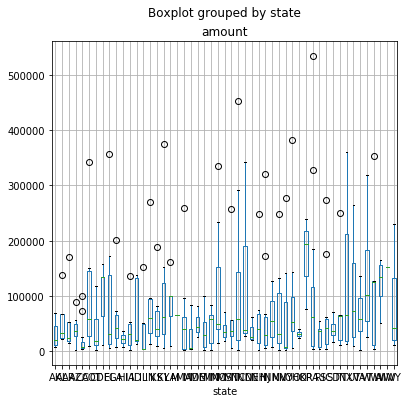

In [306]:
data.boxplot('amount', by='state', figsize=(6,6))

In [312]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [359]:
data.head()

,Unnamed: 0,firstName,lastName,amount,state,party,issue,cycle,chamber,population,amount_per_capita
0,0,John,Cornyn,65225,TX,R,Gun Rights,2014,Senate,28701845,0.002273
1,1,Mitch,McConnell,61550,KY,R,Gun Rights,2014,Senate,4468402,0.013774
2,2,James M,Inhofe,39250,OK,R,Gun Rights,2014,Senate,3943079,0.009954
3,3,Rand,Paul,37226,KY,R,Gun Rights,2014,Senate,4468402,0.008331
4,4,Pat,Roberts,36450,KS,R,Gun Rights,2014,Senate,2911505,0.012519


In [313]:
anova_state = ols('amount_per_capita~state',data=data).fit() 
anova_state.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.9196
Date:                Fri, 04 Oct 2019   Prob (F-statistic):              0.630
Time:                        08:55:37   Log-Likelihood:                -4255.9
No. Observations:                 334   AIC:                             8614.
Df Residuals:                     283   BIC:                             8808.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.016e+04   4.02e+04      0.750      0.454   -4.89e+04    1.09e+05
state[T.AL]  2.591e+04   6.03e+04      0.430      0.668   -9.28e+04    1.45e+05
state[T.AR]  2.531e+04   5.68e+04      0.445      0.656   -8.66e+04    1.37e+05
state[T.AZ]  8363.2500   5.12e+04      0.163      0.870   -9.25e+04    1.09e+05
state[T.CA] -8287.2727   4.85e+04     -0.171      0.864   -1.04e+05    8.71e+04
state[T.CO]   7.11e+04   5.12e+04      1.388      0.166   -2.97e+04    1.72e+05
state[T.CT]  8905.1667   5.44e+04      0.164      0.870   -9.82e+04    1.16e+05
state[T.DE]  6.968e+04   5.68e+04      1.226      0.221   -4.22e+04    1.82e+05
state[T.FL]  5.394e+04   4.92e+04      1.096      0.274   -4.29e+04    1.51e+05
state[T.GA]   2.56e+04   4.92e+04      0.520      0.603   -7.13e+04    1.22e+05
state[T.HI] -8497.5000   7.52e+04     -0.113      0.910   -1.56e+05    1.39e+05
state[T.IA]  1.305e+04   5.44e+04      0.240      0.811   -9.41e+04     1.2e+05
state[T.ID]  3.362e+04   5.68e+04      0.592      0.555   -7.82e+04    1.45e+05
state[T.IL]  1386.1111   5.01e+04      0.028      0.978   -9.73e+04       1e+05
state[T.IN]  5.528e+04   5.26e+04      1.051      0.294   -4.83e+04    1.59e+05
state[T.KS]  3.301e+04   5.44e+04      0.607      0.545   -7.41e+04     1.4e+05
state[T.KY]  6.461e+04   4.85e+04      1.333      0.184   -3.08e+04     1.6e+05
state[T.LA]   5.63e+04   5.68e+04      0.991      0.323   -5.56e+04    1.68e+05
state[T.M ]  3.439e+04   9.84e+04      0.349      0.727   -1.59e+05    2.28e+05
state[T.MA]  1.901e+04   4.73e+04      0.402      0.688   -7.41e+04    1.12e+05
state[T.MD] -4850.7143   5.26e+04     -0.092      0.927   -1.08e+05    9.87e+04
state[T.ME]  1.976e+04   6.56e+04      0.301      0.764   -1.09e+05    1.49e+05
state[T.MI]  6340.3333   5.44e+04      0.117      0.907   -1.01e+05    1.13e+05
state[T.MN]  1.555e+04   5.12e+04      0.304      0.762   -8.53e+04    1.16e+05
state[T.MO]  8.166e+04   5.26e+04      1.552      0.122   -2.19e+04    1.85e+05
state[T.MS]  8667.2000   5.68e+04      0.152      0.879   -1.03e+05    1.21e+05
state[T.MT]    4.6e+04   5.68e+04      0.809      0.419   -6.59e+04    1.58e+05
state[T.NC]  8.758e+04   4.92e+04      1.779      0.076   -9301.566    1.84e+05
state[T.ND]  1.058e+05   6.56e+04      1.613      0.108   -2.33e+04    2.35e+05
state[T.NE]  5318.3333   6.56e+04      0.081      0.935   -1.24e+05    1.34e+05
state[T.NH]  3.101e+04   5.12e+04      0.605      0.545   -6.98e+04    1.32e+05
state[T.NJ]  3.946e+04   4.92e+04      0.802      0.423   -5.74e+04    1.36e+05
state[T.NM]  3.059e+04   6.03e+04      0.507      0.612   -8.81e+04    1.49e+05
state[T.NV]  4.366e+04   5.26e+04      0.830      0.407   -5.99e+04    1.47e+05
state[T.NY]  2.753e+04   4.85e+04      0.568      0.570   -6.79e+04    1.23e+05
state[T.OH]  6.893e+04   5.01e+04      1.37

In [316]:
anova_table = sm.stats.anova_lm(anova_state, type=2)
print(anova_table)

             df        sum_sq       mean_sq         F   PR(>F)
state      50.0  3.713019e+11  7.426038e+09  0.919584  0.62974
Residual  283.0  2.285347e+12  8.075429e+09       NaN      NaN


# time to carve the tukey
i spent a while thinking of that one

In [317]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [318]:
mult = MultiComparison(data['amount'], data['state'])
turkey = mult.tukeyhsd()
 # interesting. maybe adjust for population
print(turkey)
print(mult.groupsunique)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
    AK     AL      25907.5    0.9 -218146.5762 269961.5762  False
    AK     AR      25314.2    0.9 -204782.1896 255410.5896  False
    AK     AZ      8363.25    0.9 -199042.8328 215769.3328  False
    AK     CA   -8287.2727    0.9 -204514.1331 187939.5877  False
    AK     CO    71102.375    0.9 -136303.7078 278508.4578  False
    AK     CT    8905.1667    0.9 -211395.3542 229205.6875  False
    AK     DE      69681.0    0.9 -160415.3896 299777.3896  False
    AK     FL      53936.0    0.9 -145333.3187 253205.3187  False
    AK     GA      25601.8    0.9 -173667.5187 224871.1187  False
    AK     HI      -8497.5    0.9 -312886.4123 295891.4123  False
    AK     IA   13045.8333    0.9 -207254.6875 233346.3542  False
    AK     ID      33624.2    0.9 -196472.1896 263720.5896  False
    AK    

#### oh no, the fastest way to do the pops is by hand... 

In [320]:
state_populations = {
        'AK': 737438,
        'AL': 4887871,
        'AR': 3013825,
        'AS': 55641,
        'AZ': 7171646,
        'CA': 39557045,
        'CO': 5695564,
        'CT': 3572665,
        'DC': 702445,
        'DE': 967171,
        'FL': 21299325,
        'GA': 10519475,
        'GU': 165718,
        'HI': 1420491,
        'IA': 3156145,
        'ID': 1754208,
        'IL': 12741080,
        'IN': 6691878,
        'KS': 2911505,
        'KY': 4468402,
        'LA': 4659978,
        'MA': 6902149,
        'MD': 6042718,
        'ME': 1338404,
        'MI': 9995915,
        'MN': 5611179,
        'MO': 6126452,
        'MP': 55194,
        'MS': 2986530,
        'MT': 1062305,
        'NA': 300000000,
        'NC': 10383620,
        'ND': 760077,
        'NE': 1929268,
        'NH': 1356458,
        'NJ': 8908520,
        'NM': 2095428,
        'NV': 3034392,
        'NY': 19542209,
        'OH': 11689442,
        'OK': 3943079,
        'OR': 4190713,
        'PA': 12807060,
        'PR': 3195153,
        'RI': 1057315,
        'SC': 5084127,
        'SD': 882235,
        'TN': 6770010,
        'TX': 28701845,
        'UT': 3161105,
        'VA': 8517685,
        'VI': 104914,
        'VT': 626299,
        'WA': 7535591,
        'WI': 5813568,
        'WV': 1805832,
        'WY': 577737
}

In [323]:
def label_pop(row):
    return state_populations[row.state]

In [327]:
test_data.iloc[298:305]

,Unnamed: 0,firstName,lastName,amount,state,party,issue,cycle,chamber
298,298,Elizabeth,Warren,96245,MA,D,Pharmaceuticals,2020,Senate
299,299,Amy,Klobuchar,64553,M,D,Pharmaceuticals,2020,Senate
300,300,Pat,Toomey,61488,PA,R,Pharmaceuticals,2020,Senate
301,301,Steven,Daines,55800,MT,R,Pharmaceuticals,2020,Senate
302,302,Gary,Peters,55702,MI,D,Pharmaceuticals,2020,Senate
303,303,Lindsey,Graham,47000,SC,R,Pharmaceuticals,2020,Senate
304,304,Mark,Warner,46227,VA,D,Pharmaceuticals,2020,Senate


In [328]:
data = pd.read_csv('final_data.csv')

In [329]:
test_data = data

#### more magical things

In [332]:
test_data['population'] = test_data.apply(lambda row: label_pop(row), axis=1)

In [334]:
def label_per_capita(row):
    return row['amount']/row['population']

In [335]:
test_data['amount_per_capita'] = test_data.apply(lambda row: label_per_capita(row), axis=1)

In [337]:
# test_data

In [340]:
anova_state = ols('amount_per_capita~state',data=test_data).fit() 
anova_state.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      amount_per_capita   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     4.889
Date:                Fri, 04 Oct 2019   Prob (F-statistic):           5.06e-18
Time:                        09:38:23   Log-Likelihood:                 611.13
No. Observations:                 334   AIC:                            -1122.
Df Residuals:                     284   BIC:                            -931.7
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0409      0.019      2.172      0.031       0.004       0.078
state[T.AL]    -0.0294      0.028     -1.042      0.298      -0.085       0.026
state[T.AR]    -0.0225      0.027     -0.845      0.399      -0.075       0.030
state[T.AZ]    -0.0355      0.024     -1.480      0.140      -0.083       0.012
state[T.CA]    -0.0403      0.023     -1.777      0.077      -0.085       0.004
state[T.CO]    -0.0231      0.024     -0.963      0.336      -0.070       0.024
state[T.CT]    -0.0300      0.025     -1.175      0.241      -0.080       0.020
state[T.DE]     0.0623      0.027      2.341      0.020       0.010       0.115
state[T.FL]    -0.0370      0.023     -1.602      0.110      -0.082       0.008
state[T.GA]    -0.0356      0.023     -1.544      0.124      -0.081       0.010
state[T.HI]    -0.0256      0.035     -0.728      0.467      -0.095       0.044
state[T.IA]    -0.0272      0.025     -1.067      0.287      -0.077       0.023
state[T.ID]    -0.0045      0.027     -0.170      0.865      -0.057       0.048
state[T.IL]    -0.0384      0.023     -1.636      0.103      -0.085       0.008
state[T.IN]    -0.0281      0.025     -1.141      0.255      -0.077       0.020
state[T.KS]    -0.0192      0.025     -0.753      0.452      -0.069       0.031
state[T.KY]    -0.0197      0.023     -0.867      0.387      -0.064       0.025
state[T.LA]    -0.0223      0.027     -0.839      0.402      -0.075       0.030
state[T.MA]    -0.0338      0.022     -1.524      0.129      -0.077       0.010
state[T.MD]    -0.0367      0.025     -1.489      0.138      -0.085       0.012
state[T.ME]    -0.0036      0.031     -0.117      0.907      -0.064       0.057
state[T.MI]    -0.0372      0.025     -1.461      0.145      -0.087       0.013
state[T.MN]    -0.0324      0.023     -1.379      0.169      -0.079       0.014
state[T.MO]    -0.0226      0.025     -0.919      0.359      -0.071       0.026
state[T.MS]    -0.0279      0.027     -1.048      0.296      -0.080       0.025
state[T.MT]     0.0308      0.027      1.156      0.249      -0.022       0.083
state[T.NC]    -0.0296      0.023     -1.282      0.201      -0.075       0.016
state[T.ND]     0.1380      0.031      4.489      0.000       0.078       0.199
state[T.NE]    -0.0225      0.031     -0.732      0.465      -0.083       0.038
state[T.NH]     0.0042      0.024      0.175      0.861      -0.043       0.051
state[T.NJ]    -0.0331      0.023     -1.435      0.153      -0.078       0.012
state[T.NM]    -0.0119      0.028     -0.422      0.674      -0.068       0.044
state[T.NV]    -0.0166      0.025     -0.672      0.502      -0.065       0.032
state[T.NY]    -0.0379      0.023     -1.671      0.096      -0.083       0.007
state[T.OH]    -0.0324      0.023     -1.381      0.169      -0.079       0.014
state[T.OK]    -0.0331      0.035     -0.93

In [341]:
anova_table = sm.stats.anova_lm(anova_state, type=2)
print(anova_table)

             df    sum_sq   mean_sq         F        PR(>F)
state      49.0  0.424705  0.008667  4.889081  5.058259e-18
Residual  284.0  0.503480  0.001773       NaN           NaN


In [345]:
# mult = MultiComparison(data['amount_per_capita'], data['state'])
# turkey = mult.tukeyhsd()
 # interesting. maybe adjust for population
print(turkey)
# print(mult.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    AK     AL  -0.0294    0.9 -0.1435  0.0847  False
    AK     AR  -0.0225    0.9   -0.13  0.0851  False
    AK     AZ  -0.0355    0.9 -0.1325  0.0614  False
    AK     CA  -0.0403    0.9 -0.1321  0.0514  False
    AK     CO  -0.0231    0.9 -0.1201  0.0738  False
    AK     CT    -0.03    0.9 -0.1329   0.073  False
    AK     DE   0.0623    0.9 -0.0452  0.1699  False
    AK     FL   -0.037    0.9 -0.1301  0.0562  False
    AK     GA  -0.0356    0.9 -0.1287  0.0575  False
    AK     HI  -0.0256    0.9 -0.1679  0.1166  False
    AK     IA  -0.0272    0.9 -0.1302  0.0758  False
    AK     ID  -0.0045    0.9 -0.1121   0.103  False
    AK     IL  -0.0384    0.9 -0.1333  0.0564  False
    AK     IN  -0.0281    0.9 -0.1277  0.0714  False
    AK     KS  -0.0192    0.9 -0.1222  0.0838  False
    AK     KY  -0.0197    0.9 -0.1114   0.072 

In [346]:
type(turkey)

statsmodels.sandbox.stats.multicomp.TukeyHSDResults

In [386]:
turkeyframe = pd.DataFrame(data=turkey._results_table.data[1:], columns=turkey._results_table.data[0])

print(turkeyframe.sort_values('meandiff', ascending=False))

     group1 group2  meandiff   p-adj   lower   upper  reject
230      CA     VT    0.2171  0.0010  0.1178  0.3164    True
590      IL     VT    0.2152  0.0010  0.1130  0.3174    True
1100     NY     VT    0.2147  0.0010  0.1154  0.3140    True
842      MI     VT    0.2140  0.0010  0.1042  0.3238    True
400      FL     VT    0.2137  0.0010  0.1131  0.3143    True
785      MD     VT    0.2135  0.0010  0.1069  0.3200    True
1199     TX     VT    0.2131  0.0010  0.1159  0.3103    True
185      AZ     VT    0.2123  0.0010  0.1081  0.3164    True
440      GA     VT    0.2123  0.0010  0.1117  0.3129    True
755      MA     VT    0.2105  0.0010  0.1133  0.3078    True
1210     VA     VT    0.2101  0.0010  0.1060  0.3142    True
1129     OK     VT    0.2098  0.0010  0.0625  0.3571    True
1049     NJ     VT    0.2098  0.0010  0.1092  0.3104    True
1115     OH     VT    0.2092  0.0010  0.1070  0.3114    True
869      MN     VT    0.2091  0.0010  0.1069  0.3113    True
1154     PA     VT    0.

In [354]:
trues = turkeyframe[turkeyframe['reject']==True]

In [357]:
trues.sort_values('meandiff', ascending=False)

,group1,group2,meandiff,p-adj,lower,upper,reject
230,CA,VT,0.2171,0.0010,0.1178,0.3164,True
590,IL,VT,0.2152,0.0010,0.1130,0.3174,True
1100,NY,VT,0.2147,0.0010,0.1154,0.3140,True
842,MI,VT,0.2140,0.0010,0.1042,0.3238,True
400,FL,VT,0.2137,0.0010,0.1131,0.3143,True
785,MD,VT,0.2135,0.0010,0.1069,0.3200,True
1199,TX,VT,0.2131,0.0010,0.1159,0.3103,True
185,AZ,VT,0.2123,0.0010,0.1081,0.3164,True
440,GA,VT,0.2123,0.0010,0.1117,0.3129,True
755,MA,VT,0.2105,0.0010,0.1133,0.3078,True


# heck yeah, that's a lot of Trues

# time for GRAPH

In [363]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<Figure size 1440x648 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

In [380]:
test_data.sort_values('amount',ascending=False)

,Unnamed: 0,firstName,lastName,amount,state,party,issue,cycle,chamber,population,amount_per_capita
197,197,Bob,Casey,535324,PA,D,Pharmaceuticals,2018,Senate,12807060,0.041799
93,93,Richard,Burr,453581,NC,R,Pharmaceuticals,2016,Senate,10383620,0.043682
94,94,Rob,Portman,383006,OH,R,Pharmaceuticals,2016,Senate,11689442,0.032765
20,20,Mitch,McConnell,375073,KY,R,Pharmaceuticals,2014,Senate,4468402,0.083939
95,95,Ted,Cruz,361003,TX,R,Pharmaceuticals,2016,Senate,28701845,0.012578
96,96,Marco,Rubio,356463,FL,R,Pharmaceuticals,2016,Senate,21299325,0.016736
97,97,Patty,Murray,353483,WA,D,Pharmaceuticals,2016,Senate,7535591,0.046908
98,98,Michael,Bennet,343087,CO,D,Pharmaceuticals,2016,Senate,5695564,0.060238
198,198,Heidi,Heitkamp,342587,ND,D,Pharmaceuticals,2018,Senate,760077,0.450727
66,66,Ted,Cruz,339789,TX,R,Gun Rights,2016,Senate,28701845,0.011839


# maybe sort the test data

In [449]:
test_data = test_data.sort_values(['state', 'amount'], ascending=True)
test_data.head(10)

,Unnamed: 0,firstName,lastName,amount,state,party,issue,cycle,chamber,population,amount_per_capita
254,254,Dan,Sullivan,7750,AK,R,Gun Rights,2020,Senate,737438,0.010509
333,333,Dan,Sullivan,10400,AK,R,Pharmaceuticals,2020,Senate,737438,0.014103
82,82,Lisa,Murkowski,18950,AK,R,Gun Rights,2016,Senate,737438,0.025697
133,133,Lisa,Murkowski,45500,AK,R,Pharmaceuticals,2016,Senate,737438,0.061700
49,49,Mark,Begich,68200,AK,D,Pharmaceuticals,2014,Senate,737438,0.092482
81,81,Richard C,Shelby,21150,AL,R,Gun Rights,2016,Senate,4887871,0.004327
143,143,Luther,Strange,23350,AL,R,Gun Rights,2018,Senate,4887871,0.004777
305,305,Doug,Jones,42631,AL,D,Pharmaceuticals,2020,Senate,4887871,0.008722
211,211,Doug,Jones,137139,AL,D,Pharmaceuticals,2018,Senate,4887871,0.028057
147,147,Tom,Cotton,14686,AR,R,Gun Rights,2018,Senate,3013825,0.004873


# magical formula to derive Zscore

In [458]:
test_data['Zscore_per_capita'] = test_data.groupby('state').amount_per_capita.apply(lambda x: x.div(x.mean()))

In [459]:
test_data.head()

,Unnamed: 0,firstName,lastName,amount,state,party,issue,cycle,chamber,population,amount_per_capita,Zscore,Zscore_per_capita
254,254,Dan,Sullivan,7750,AK,R,Gun Rights,2020,Senate,737438,0.010509,0.256963,0.256963
333,333,Dan,Sullivan,10400,AK,R,Pharmaceuticals,2020,Senate,737438,0.014103,0.344828,0.344828
82,82,Lisa,Murkowski,18950,AK,R,Gun Rights,2016,Senate,737438,0.025697,0.628316,0.628316
133,133,Lisa,Murkowski,45500,AK,R,Pharmaceuticals,2016,Senate,737438,0.061700,1.508621,1.508621
49,49,Mark,Begich,68200,AK,D,Pharmaceuticals,2014,Senate,737438,0.092482,2.261273,2.261273


ValueError: `dataset` input should have multiple elements.

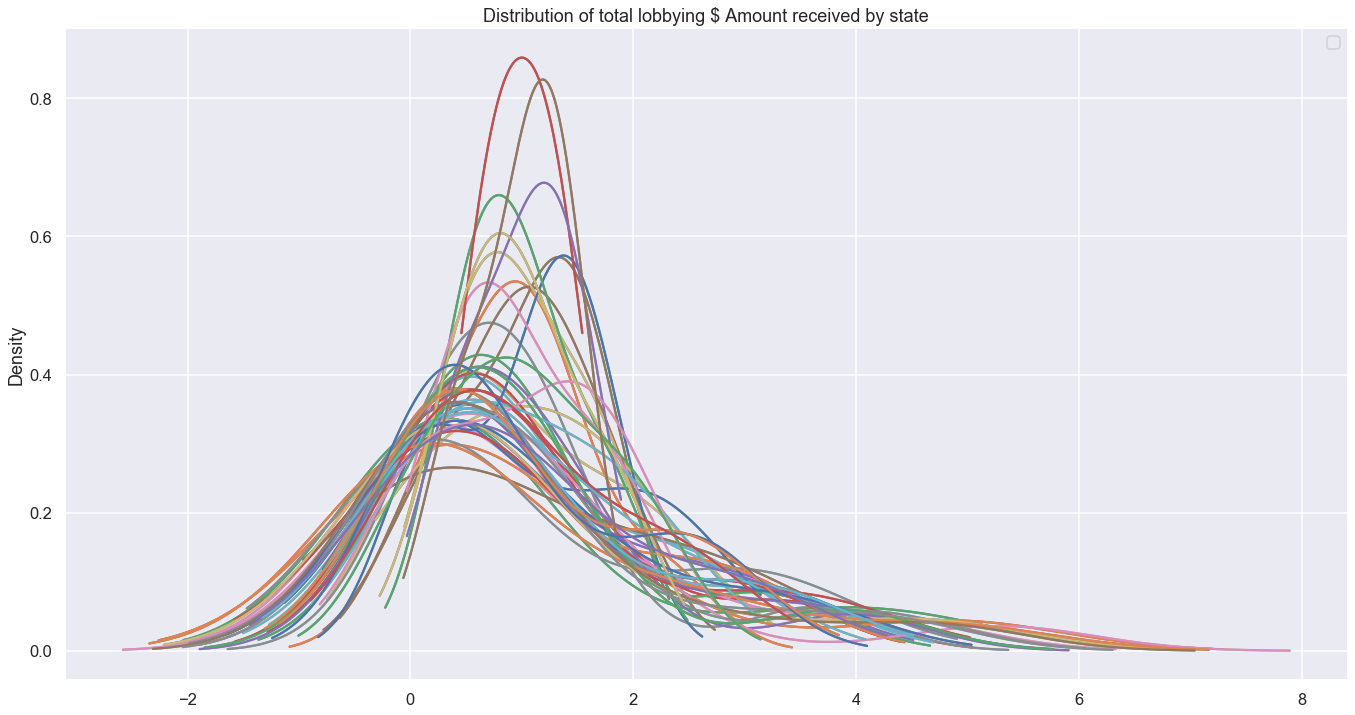

In [457]:
plt.figure(figsize=(23, 12))
plt.legend('each curve is a state')
plt.title('Distribution of total lobbying $ Amount received by state')
test_data.groupby('state').Zscore.plot.kde()

ValueError: `dataset` input should have multiple elements.

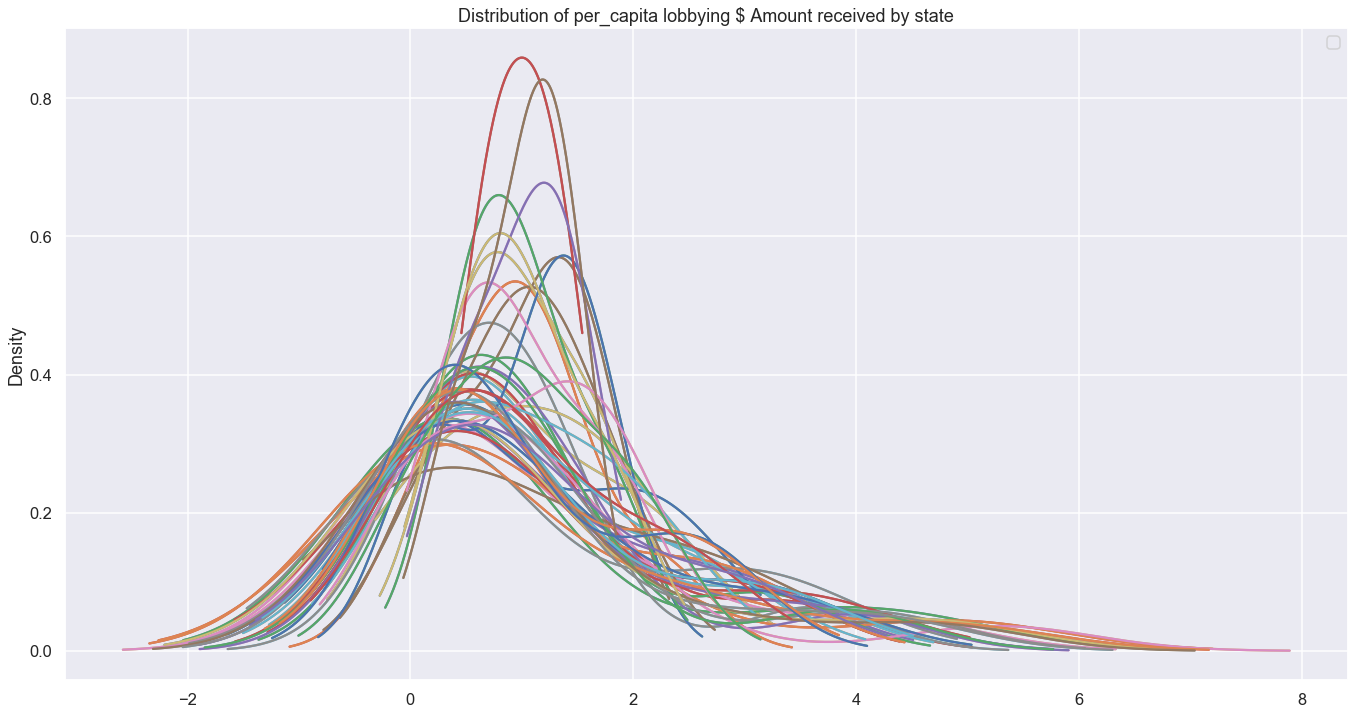

In [460]:
plt.figure(figsize=(23, 12))
plt.legend('each curve is a state')
plt.title('Distribution of per_capita lobbying $ Amount received by state')
test_data.groupby('state').Zscore_per_capita.plot.kde()

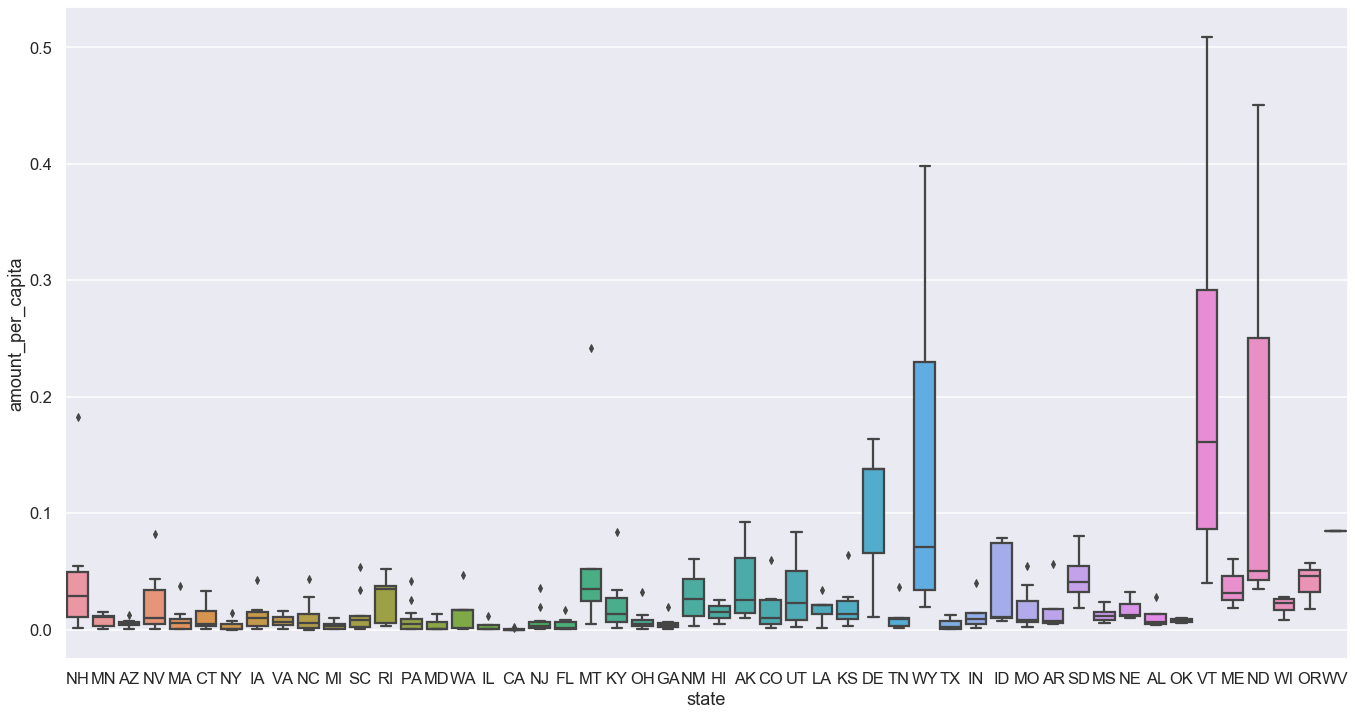

In [444]:
sns.set() # settings to default
sns.set_style('darkgrid') # background to darkgrid
sns.set_context('talk') # text size to 3. paper=1,notebook=2,poster=4
plt.figure(figsize=(23, 12)) # figure size, width height
ax = sns.boxplot(x='state',y='amount_per_capita',data=test_data) # pass it a dataframe. i love seaborn

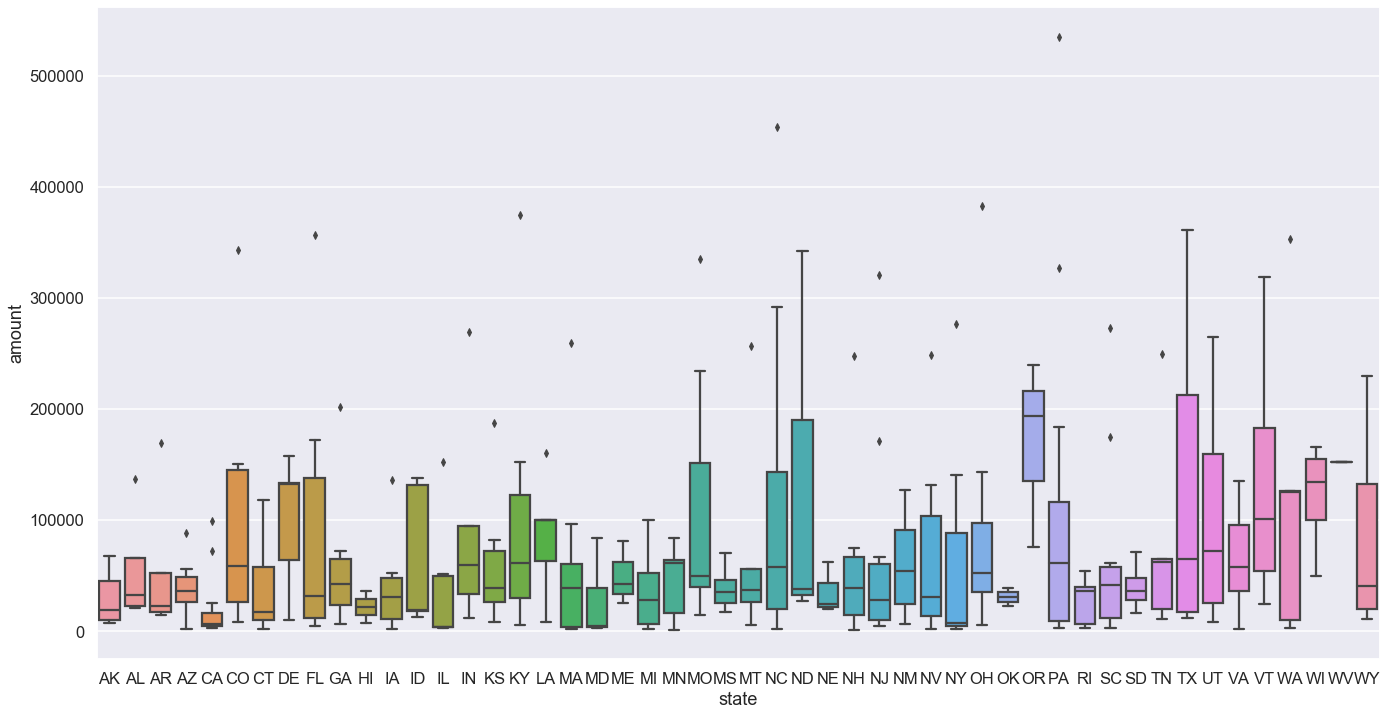

In [450]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')
plt.figure(figsize=(23, 12))
ax = sns.boxplot(x='state',y='amount',data=test_data)

In [ ]:
# now: let's do a correlational analysis
## between amount_per_capita and

# lets try again for a correlational

### pull data from SQL server

In [395]:
host = "flatiron-pk.cwj0dr22eqpl.us-east-2.rds.amazonaws.com"
user = 'pek82'
passwd = "monkey82"

DB_NAME = 'lobby_boys'

In [404]:
database_cnx = mysql.connector.connect(
    host = host,
    user = user,
    passwd = passwd,
    database = DB_NAME
)
database_cursor = database_cnx.cursor(buffered=True)

In [405]:
query = '''
SELECT * from firearmdeaths
'''

In [411]:
database_cursor.execute(query)

In [415]:
for row in database_cursor:
    print(row)

(2017, 'AL', 22.9, '1,124', '/nchs/pressroom/states/alabama/alabama.htm')
(2017, 'AK', 24.5, '180', '/nchs/pressroom/states/alaska/alaska.htm')
(2017, 'AZ', 15.8, '1,134', '/nchs/pressroom/states/arizona/arizona.htm')
(2017, 'AR', 20.3, '613', '/nchs/pressroom/states/arkansas/arkansas.htm')
(2017, 'CA', 7.9, '3,184', '/nchs/pressroom/states/california/california.htm')
(2017, 'CO', 13.4, '779', '/nchs/pressroom/states/colorado/colorado.htm')
(2017, 'CT', 5.1, '188', '/nchs/pressroom/states/connecticut/connecticut.htm')
(2017, 'DE', 11.7, '111', '/nchs/pressroom/states/delaware/delaware.htm')
(2017, 'FL', 12.4, '2,724', '/nchs/pressroom/states/florida/florida.htm')
(2017, 'GA', 15.4, '1,623', '/nchs/pressroom/states/georgia/georgia.htm')
(2017, 'HI', 2.5, '39', '/nchs/pressroom/states/hawaii/hawaii.htm')
(2017, 'ID', 16.4, '280', '/nchs/pressroom/states/idaho/idaho.htm')
(2017, 'IL', 12.1, '1,543', '/nchs/pressroom/states/illinois/illinois.htm')
(2017, 'IN', 15.3, '1,016', '/nchs/pressro

# Let's get the gun rates

# magic function to read query results to DataFrame

In [427]:
def read_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute( query )
        names = [ x[0] for x in cursor.description]
        rows = cursor.fetchall()
        return pd.DataFrame( rows, columns=names)
    finally:
        if cursor is not None:
            cursor.close()

In [428]:
df = read_query(database_cnx, query)

In [430]:
df.head()

,YEAR,STATE,RATE,DEATHS,URL
0,2017,AL,22.9,"1,124",/nchs/pressroom/states/alabama/alabama.htm
1,2017,AK,24.5,180,/nchs/pressroom/states/alaska/alaska.htm
2,2017,AZ,15.8,"1,134",/nchs/pressroom/states/arizona/arizona.htm
3,2017,AR,20.3,613,/nchs/pressroom/states/arkansas/arkansas.htm
4,2017,CA,7.9,"3,184",/nchs/pressroom/states/california/california.htm


In [438]:
state_gun_rates = df.groupby('STATE').mean()
state_gun_rates = state_gun_rates.drop('YEAR', axis=1)

In [441]:
state_gun_rates.head(10)

,RATE
STATE,
AK,21.58
AL,19.38
AR,17.46
AZ,14.88
CA,8.08
CO,12.82
CT,5.06
DE,10.94
FL,11.70


In [461]:
drug_query = '''
SELECT * from overdosedeaths
'''

In [462]:
drug_df = read_query(database_cnx, drug_query)

,YEAR,STATE,RATE,DEATHS,URL
0,2017,AL,18.0,835,/nchs/pressroom/states/alabama/alabama.htm
1,2017,AK,20.2,147,/nchs/pressroom/states/alaska/alaska.htm
2,2017,AZ,22.2,"1,532",/nchs/pressroom/states/arizona/arizona.htm
3,2017,AR,15.5,446,/nchs/pressroom/states/arkansas/arkansas.htm
4,2017,CA,11.7,"4,868",/nchs/pressroom/states/california/california.htm
5,2017,CO,17.6,"1,015",/nchs/pressroom/states/colorado/colorado.htm
6,2017,CT,30.9,"1,072",/nchs/pressroom/states/connecticut/connecticut...
7,2017,DE,37.0,338,/nchs/pressroom/states/delaware/delaware.htm
8,2017,FL,25.1,"5,088",/nchs/pressroom/states/florida/florida.htm
9,2017,GA,14.7,"1,537",/nchs/pressroom/states/georgia/georgia.htm


In [465]:
drug_df = drug_df.groupby('STATE').mean()
drug_df = drug_df.drop('YEAR', axis=1)

In [ ]:
# state_gun_rates, drug_df, can we merge them?

In [466]:
drug_df

,RATE
STATE,
AK,14.783333
AL,12.550000
AR,12.666667
AZ,16.466667
CA,10.400000
CO,14.433333
CT,19.250000
DE,20.766667
FL,16.350000


In [468]:
joint = pd.concat([state_gun_rates, drug_df], axis=1)

In [474]:
joint.head()

,RATE,RATE
STATE,,
AK,21.58,14.783333
AL,19.38,12.550000
AR,17.46,12.666667
AZ,14.88,16.466667
CA,8.08,10.400000


In [471]:
joint.columns['gun_death_rate', 'drug_overdose_rate']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [476]:
joint.rename(columns={'RATE': 'gun_death_rate', 'RATE': 'drug_death_rate'}, inplace=True)

In [478]:
joint.head()

,drug_death_rate,drug_death_rate
STATE,,
AK,21.58,14.783333
AL,19.38,12.550000
AR,17.46,12.666667
AZ,14.88,16.466667
CA,8.08,10.400000


In [481]:
test_data.head(15)

,Unnamed: 0,firstName,lastName,amount,state,party,issue,cycle,chamber,population,amount_per_capita,Zscore,Zscore_per_capita
254,254,Dan,Sullivan,7750,AK,R,Gun Rights,2020,Senate,737438,0.010509,0.256963,0.256963
333,333,Dan,Sullivan,10400,AK,R,Pharmaceuticals,2020,Senate,737438,0.014103,0.344828,0.344828
82,82,Lisa,Murkowski,18950,AK,R,Gun Rights,2016,Senate,737438,0.025697,0.628316,0.628316
133,133,Lisa,Murkowski,45500,AK,R,Pharmaceuticals,2016,Senate,737438,0.061700,1.508621,1.508621
49,49,Mark,Begich,68200,AK,D,Pharmaceuticals,2014,Senate,737438,0.092482,2.261273,2.261273
81,81,Richard C,Shelby,21150,AL,R,Gun Rights,2016,Senate,4887871,0.004327,0.377224,0.377224
143,143,Luther,Strange,23350,AL,R,Gun Rights,2018,Senate,4887871,0.004777,0.416462,0.416462
305,305,Doug,Jones,42631,AL,D,Pharmaceuticals,2020,Senate,4887871,0.008722,0.760351,0.760351
211,211,Doug,Jones,137139,AL,D,Pharmaceuticals,2018,Senate,4887871,0.028057,2.445962,2.445962
147,147,Tom,Cotton,14686,AR,R,Gun Rights,2018,Senate,3013825,0.004873,0.264736,0.264736


# get the avg of each state's amount_per_capita

In [490]:
sums = test_data.groupby(['state']).sum()

In [491]:
sums.head()

,Unnamed: 0,amount,cycle,population,amount_per_capita,Zscore,Zscore_per_capita
state,,,,,,,
AK,851,150800,10086,3687190,0.204492,5.0,5.0
AL,740,224270,8072,19551484,0.045883,4.0,4.0
AR,711,277371,10084,15069125,0.092033,5.0,5.0
AZ,1651,308186,16146,57373168,0.042973,8.0,8.0
CA,2510,240600,22208,435127495,0.006082,11.0,11.0


In [ ]:
# joint = pd.concat([state_gun_rates, drug_df], axis=1)

In [494]:
voltron = pd.concat([joint, sums.amount_per_capita], axis=1)

In [500]:
# col names got messed up
# joint.rename(columns={'RATE': 'gun_death_rate', 'RATE': 'drug_death_rate'}, inplace=True)
# voltron.rename(columns={'drug_death_rate': 'gun_death_rate', 'drug_death_rate':'drug_death_rate', 'amount_per_capita':'amount_per_capita'},inplace=True)

voltron.columns = ['gun_death_rate', 'drug_death_rate', 'amount_per_capita']

# df1.columns = ['Customer_unique_id', 'Product_type', 'Province']



In [501]:
voltron.head()

,gun_death_rate,drug_death_rate,amount_per_capita
AK,21.58,14.783333,0.204492
AL,19.38,12.550000,0.045883
AR,17.46,12.666667,0.092033
AZ,14.88,16.466667,0.042973
CA,8.08,10.400000,0.006082


# we have merged our gun death rates, drug OD rates 
# and money received by state total
## let's graph

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(setosa.sepal_width, setosa.sepal_length,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(virginica.sepal_width, virginica.sepal_length,
                 cmap="Blues", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(2.5, 8.2, "virginica", size=16, color=blue)
ax.text(3.8, 4.5, "setosa", size=16, color=red)

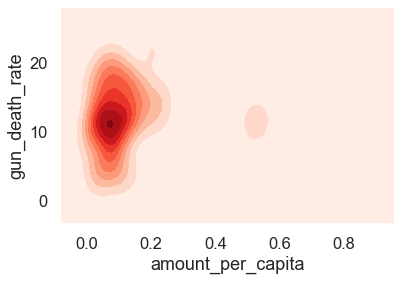

In [507]:
# ax = plt.subplots(figsize = (23,12))
# ax.set_aspect('equal')
ax = sns.kdeplot(voltron.amount_per_capita, voltron.gun_death_rate,
                cmap='Reds', shade=True, shade_lowers=False)
states = sns.color_palette("Reds")[-2]


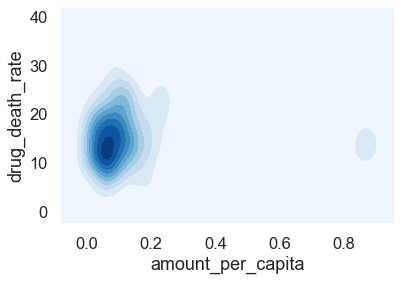

In [508]:
# ax = plt.subplots(figsize = (23,12))
# ax.set_aspect('equal')
ax = sns.kdeplot(voltron.amount_per_capita, voltron.drug_death_rate,
                cmap='Blues', shade=True, shade_lowers=False)
states = sns.color_palette("Blues")[-2]


In [512]:
voltron.sort_values('drug_death_rate', ascending=False)

,gun_death_rate,drug_death_rate,amount_per_capita
WV,15.70,33.566667,0.084528
OH,11.68,25.833333,0.076294
PA,11.44,25.283333,0.115569
NH,8.78,25.250000,0.360751
KY,15.16,24.250000,0.233307
NM,17.02,22.950000,0.115961
RI,3.86,22.200000,0.132816
MD,11.40,21.766667,0.029319
MA,3.34,21.500000,0.092612
DE,10.94,20.766667,0.516150


In [ ]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')
plt.figure(figsize=(23,12))
ax = 